In [1]:
import pandas as pd

df = pd.read_csv('bank-full.csv', delimiter=';')

print(df.head())

print(f"Dataset shape: {df.shape}")

print(df['y'].value_counts())

   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
Dataset shape: (45211, 17)
y
no     39922
yes     5289
Name: count, dtype: int64


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

df = df.drop('duration', axis=1)

categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

df['y'] = LabelEncoder().fit_transform(df['y'])

X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [3]:
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=5,
    class_weight='balanced',  
    random_state=42
)

dt_model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=5, random_state=42)

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = dt_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.85      0.89     11966
           1       0.30      0.49      0.37      1598

    accuracy                           0.81     13564
   macro avg       0.61      0.67      0.63     13564
weighted avg       0.85      0.81      0.82     13564


Confusion Matrix:
[[10141  1825]
 [  810   788]]


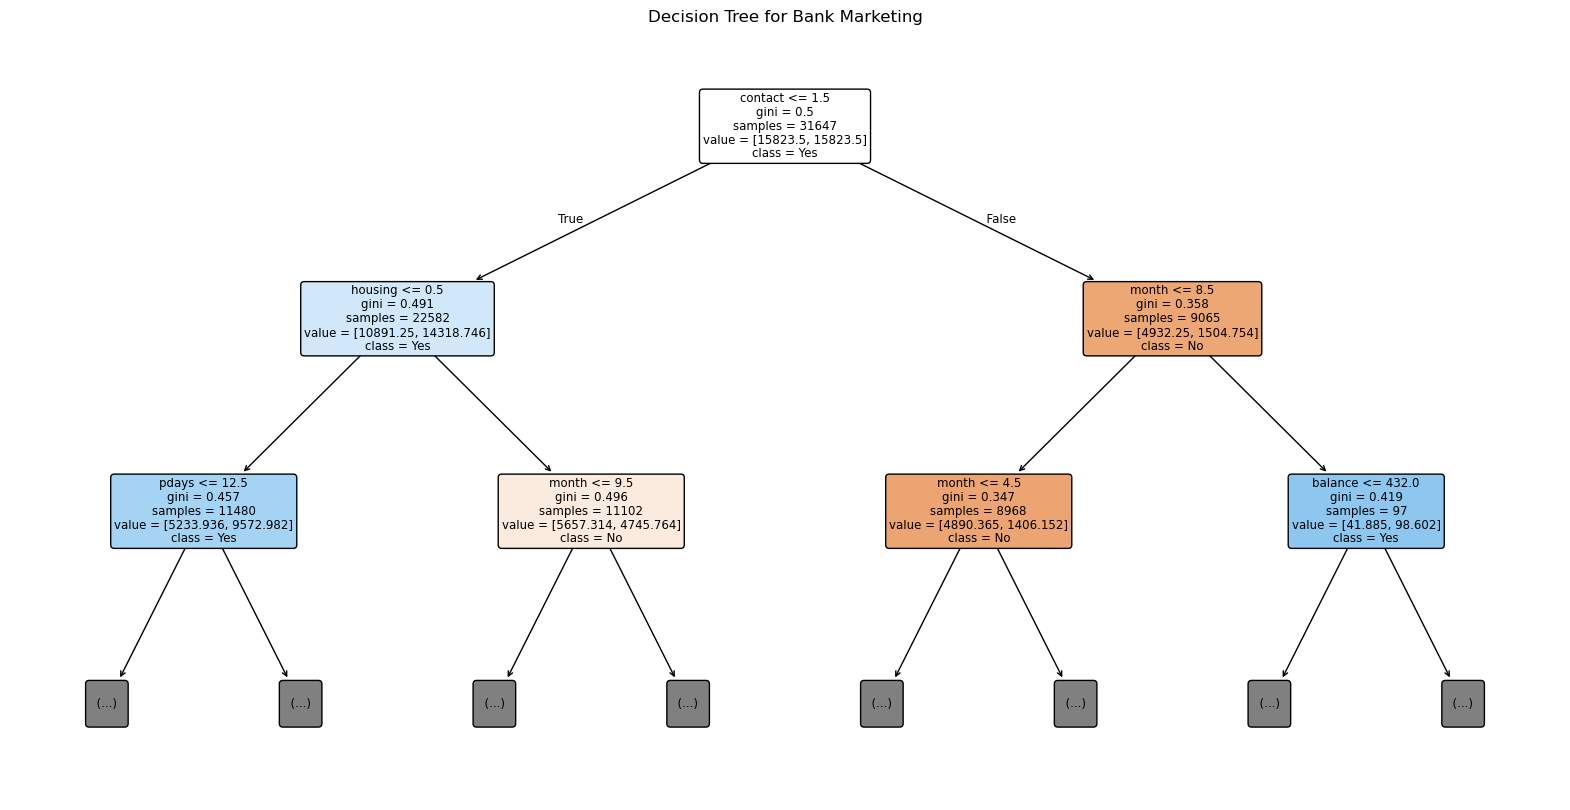

In [5]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    max_depth=2  
)
plt.title("Decision Tree for Bank Marketing")
plt.show()

In [6]:
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(feature_importance)

      Feature  Importance
8     contact    0.372846
10      month    0.219547
12      pdays    0.179607
6     housing    0.143561
14   poutcome    0.033325
13   previous    0.015708
7        loan    0.012682
0         age    0.009613
5     balance    0.008145
9         day    0.004071
11   campaign    0.000895
1         job    0.000000
2     marital    0.000000
3   education    0.000000
4     default    0.000000


In [7]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_split': [10, 20, 30],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 10}


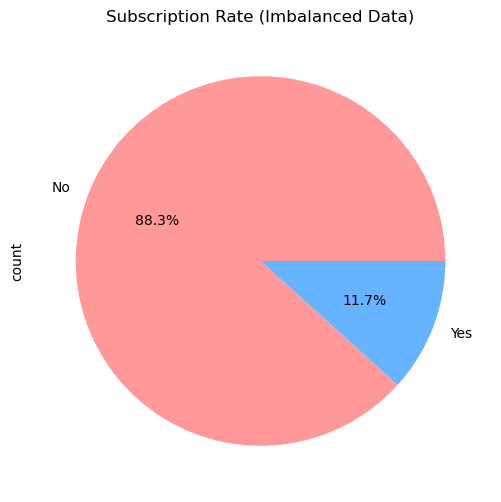

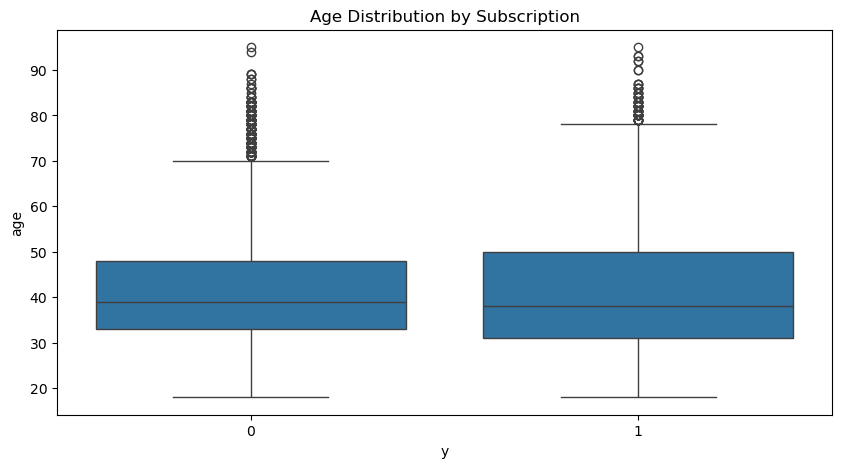

<Figure size 1200x600 with 0 Axes>

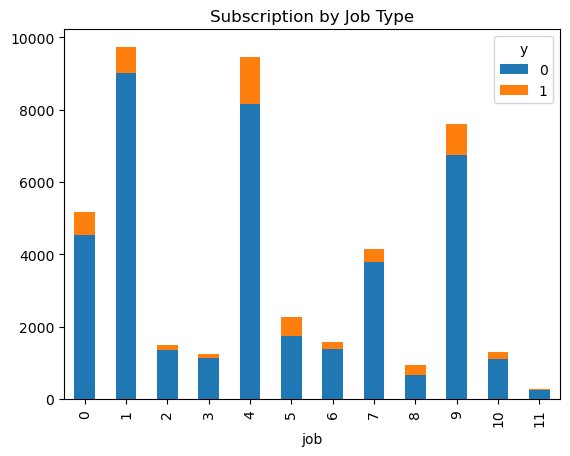

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Pie chart for target distribution
plt.figure(figsize=(6,6))
df['y'].value_counts().plot.pie(
    autopct='%1.1f%%', 
    labels=['No', 'Yes'], 
    colors=['#ff9999','#66b3ff']
)
plt.title("Subscription Rate (Imbalanced Data)")
plt.show()

# Boxplot for age distribution
plt.figure(figsize=(10,5))
sns.boxplot(x='y', y='age', data=df)
plt.title("Age Distribution by Subscription")
plt.show()

# Stacked bar chart for job types
plt.figure(figsize=(12,6))
job_counts = df.groupby(['job', 'y']).size().unstack()
job_counts.plot(kind='bar', stacked=True)
plt.title("Subscription by Job Type")
plt.show()

In [9]:
df['age_group'] = pd.cut(df['age'], 
                         bins=[0, 30, 50, 70, 100], 
                         labels=['Young', 'Middle', 'Senior', 'Elderly'])

df['contact_freq'] = df['campaign'].apply(
    lambda x: 'Low' if x < 3 else ('Medium' if x < 6 else 'High')
)

df['prev_success'] = df['poutcome'].apply(
    lambda x: 1 if x == 'success' else 0
)

df = pd.get_dummies(df, columns=['age_group', 'contact_freq'])

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'criterion': ['gini', 'entropy']
}

dt = DecisionTreeClassifier(class_weight='balanced')
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

best_dt = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 15, 'min_samples_split': 10}


In [11]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

best_dt.fit(X_res, y_res)
y_pred = best_dt.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86     11966
           1       0.26      0.54      0.35      1598

    accuracy                           0.76     13564
   macro avg       0.59      0.67      0.60     13564
weighted avg       0.85      0.76      0.80     13564



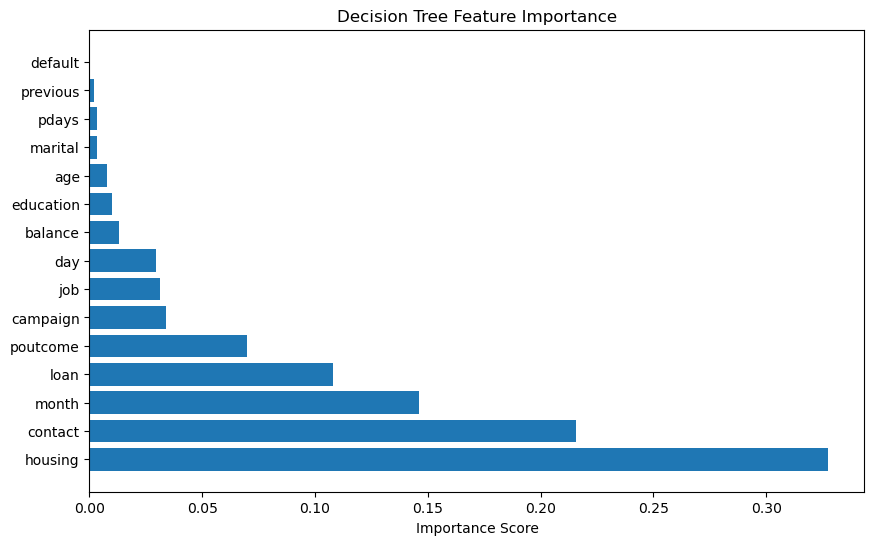

In [12]:
import matplotlib.pyplot as plt

importances = best_dt.feature_importances_
features = X_train.columns

feature_imp = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_imp = feature_imp.sort_values('Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_imp['Feature'], feature_imp['Importance'])
plt.title("Decision Tree Feature Importance")
plt.xlabel("Importance Score")
plt.show()

In [13]:
from sklearn.tree import export_text

tree_rules = export_text(
    best_dt, 
    feature_names=list(X_train.columns))
print(tree_rules)

|--- housing <= 0.50
|   |--- contact <= 1.50
|   |   |--- loan <= 0.50
|   |   |   |--- poutcome <= 2.50
|   |   |   |   |--- poutcome <= 0.50
|   |   |   |   |   |--- month <= 7.50
|   |   |   |   |   |   |--- contact <= 0.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- contact >  0.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- month >  7.50
|   |   |   |   |   |   |--- balance <= 66.00
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- balance >  66.00
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- poutcome >  0.50
|   |   |   |   |   |--- campaign <= 4.50
|   |   |   |   |   |   |--- marital <= 1.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- marital >  1.50
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- campaign >  4.50
|   |   |   |   |   |   |--- day <= 9.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- day >  9.50
|   |   

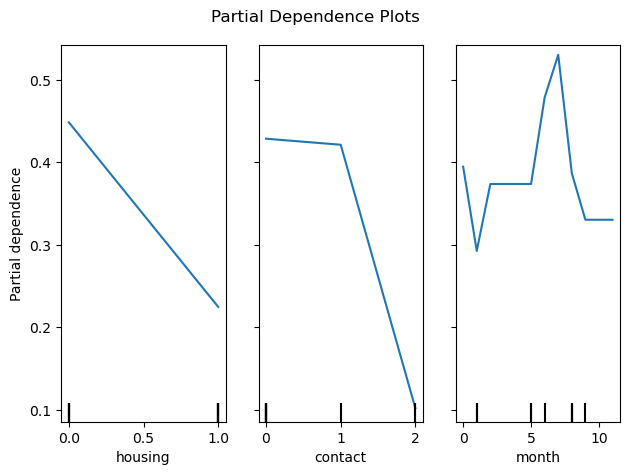

In [14]:
from sklearn.inspection import PartialDependenceDisplay

top_features = feature_imp['Feature'][:3]
PartialDependenceDisplay.from_estimator(
    best_dt, 
    X_train, 
    features=top_features,
    grid_resolution=20
)
plt.suptitle("Partial Dependence Plots")
plt.tight_layout()
plt.show()